# Machine Learning technique on PET block detector development - Part 2-1

## Crystal/Pixel discrimination for DQS PET block detector using Machine Learning techniques (v1.0, 2019-09)
---


- This report describes the algorithm(s) to discrimanate the scintillation crystals (pixels) being fired by gammas in the block detectors
- The block under investigation is built using the Dichotomous Orthogonal Symmetry ([DOS](https://iopscience.iop.org/article/10.1088/0031-9155/61/4/1608)) design (https://iopscience.iop.org/article/10.1088/0031-9155/61/4/1608)
- The raw data is generated by Monte Carlo simulations using [GATE](http://www.opengatecollaboration.org/) (http://www.opengatecollaboration.org/)
- In order to read root file, the **uproot** package is needed ([link1](https://pypi.org/project/uproot/), [link2](https://github.com/scikit-hep/uproot)).
---

In [8]:
# load libraries

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook

import pickle
from sklearn.externals import joblib
import time

plt.rcParams['figure.dpi'] = 120 # default is 72

### 1. Raw data structure
***
- There are two TTree in the Monte Carlo simulation generated root file: **OpticalSinglesOpticaladder** and **SinglesAdder**.  
  Each tree consists of a series of records which has 26 fields:
  'runID',
  'eventID',
  'sourceID',
  'sourcePosX',
  'sourcePosY',
  'sourcePosZ',
  'time',  
  'energy',
  'globalPosX',
  'globalPosY',
  'globalPosZ',
  'gantryID',
  'rsectorID',
  'moduleID',
  'submoduleID',
  'crystalID',
  'layerID',  
  'comptonPhantom',
  'comptonCrystal',
  'RayleighPhantom',
  'RayleighCrystal',
  'axialPos',
  'rotationAngle',
  'comptVolName',  
  'RayleighVolName',
  'septalNb'.  
    
- The energy in the OpticalSinglesOpticaladder tree is the number of photons received by each photo sensors (SiPMs),  
while the energy in the SinglesAdder tree is the deposited energy (in MeV) at each interaction location inside the  
scintillation crystal pixels.  
  
- The records with the same runID and eventID in both the SinglesAdder and the OpticalSinglesOpticaladder trees are  
from the same gammas. Since each gamma may interact with the scintillator several times, and the photo sensors that  
received scintillation photons are different for each gamma, therefore, the number of records for the same gamma in the  
SinglesAdder and the OpticalSinglesOpticaladder are usually different. Therefore, sorting algorithms are needed to   
convert the raw data into a organized format for further investigation.  
---

In [9]:
# load raw data from root files
file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\new_concept_block4a_planar_source001.root"
fp = uproot.open(file)


In [10]:
fp.allkeys()

[b'latest_event_ID;1',
 b'total_nb_primaries;1',
 b'OpticalSinglesOpticaladder;1',
 b'SinglesAdder;1']

In [11]:
fp.allvalues()

[<b'TH1D' b'latest_event_ID' 0x01cd8e8e1098>,
 <b'TH1D' b'total_nb_primaries' 0x01cd8e8c8a98>,
 <TTree b'OpticalSinglesOpticaladder' at 0x01cd8e8e8160>,
 <TTree b'SinglesAdder' at 0x01cd8f13f940>]

In [12]:
fp.allitems()

[(b'latest_event_ID;1', <b'TH1D' b'latest_event_ID' 0x01cd8e8c8f98>),
 (b'total_nb_primaries;1', <b'TH1D' b'total_nb_primaries' 0x01cd8e8c8db8>),
 (b'OpticalSinglesOpticaladder;1',
  <TTree b'OpticalSinglesOpticaladder' at 0x01cd8f7065c0>),
 (b'SinglesAdder;1', <TTree b'SinglesAdder' at 0x01cd91cf1da0>)]

In [13]:
# optical singles adder consists of the photon counts received by each photo sensor
# sigles adder consists of the photon counts deposited at each interaction within the scintillator

opticalsinglesadder = fp["OpticalSinglesOpticaladder"]
singlesadder = fp["SinglesAdder"]


In [14]:
singlesadder.show()

runID                      (no streamer)              asdtype('>i4')
eventID                    (no streamer)              asdtype('>i4')
sourceID                   (no streamer)              asdtype('>i4')
sourcePosX                 (no streamer)              asdtype('>f4')
sourcePosY                 (no streamer)              asdtype('>f4')
sourcePosZ                 (no streamer)              asdtype('>f4')
time                       (no streamer)              asdtype('>f8')
energy                     (no streamer)              asdtype('>f4')
globalPosX                 (no streamer)              asdtype('>f4')
globalPosY                 (no streamer)              asdtype('>f4')
globalPosZ                 (no streamer)              asdtype('>f4')
gantryID                   (no streamer)              asdtype('>i4')
rsectorID                  (no streamer)              asdtype('>i4')
moduleID                   (no streamer)              asdtype('>i4')
submoduleID                (no str

In [15]:
opticalsinglesadder.show()

runID                      (no streamer)              asdtype('>i4')
eventID                    (no streamer)              asdtype('>i4')
sourceID                   (no streamer)              asdtype('>i4')
sourcePosX                 (no streamer)              asdtype('>f4')
sourcePosY                 (no streamer)              asdtype('>f4')
sourcePosZ                 (no streamer)              asdtype('>f4')
time                       (no streamer)              asdtype('>f8')
energy                     (no streamer)              asdtype('>f4')
globalPosX                 (no streamer)              asdtype('>f4')
globalPosY                 (no streamer)              asdtype('>f4')
globalPosZ                 (no streamer)              asdtype('>f4')
gantryID                   (no streamer)              asdtype('>i4')
rsectorID                  (no streamer)              asdtype('>i4')
moduleID                   (no streamer)              asdtype('>i4')
submoduleID                (no str

In [16]:
opticalsinglesadder.name, opticalsinglesadder.title, opticalsinglesadder.numbranches, opticalsinglesadder.numentries

(b'OpticalSinglesOpticaladder', b'The root tree for singles', 26, 8064316)

In [17]:
singlesadder.name, singlesadder.title, singlesadder.numbranches, singlesadder.numentries

(b'SinglesAdder', b'The root tree for singles', 26, 446353)

###  
### 2. Sorting the raw data
***
- A C-like code for Root is developed sorting and filtering the raw events and converting them into a more straight forward  
data structure. The converted data is stored using CSV format as ASCII file.

- The number of fields in the CSV is determined by the structure of the simulated block detector. For the 15 $\times$ 15 LSO  
block in this study, the number of fields is $N_s\times4+4$, where $N_s=9$ is the number of photo sensors along one side of the block.


- The first 3 fields are the "index_x","index_y","index_z", which is the pixel index in X, Y and Z direction. The pixel index in X and Y  
direction are the real pixel/crystal index, however, the pixle/crystal along Z direction is one complete unit in this simualtion.  
Thus the Z index is the discreted index based on delta_z parameter during the sorting.  
  
- The fourth field is the total deposited energy by the gamma in MeV unit.  

- The rest of the fields are the number of photons received by each photo sensors. The first $N_s\times2$ fields are for the sensors on  
the top: "$st0$" to "$st[N_s\times2-1]$", the second $N_s\times2$ fields are the for the sensors on the bottom: "$sb0$" to "$sb[N_s\times2-1]$". 
  
---

In [18]:
file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\ML_data\\new_concept_block_15x15_sorted_events1.csv"

df0 = pd.read_csv (file, comment='#')

In [19]:
df0.head()


,index_x,index_y,index_z,energy,st0,st1,st2,st3,st4,st5,...,sb8,sb9,sb10,sb11,sb12,sb13,sb14,sb15,sb16,sb17
0,8,3,5,0.511000,10,1,38,1,45,2,...,6,91,4,16,5,12,1,10,1,4
1,9,9,2,0.481130,5,1,5,4,6,2,...,19,4,93,0,33,2,10,0,7,0
2,5,2,6,0.511000,6,0,24,0,4,2,...,2,44,4,175,1,62,0,27,0,6
3,7,6,8,0.511000,3,2,1,2,7,2,...,6,34,5,7,0,8,1,5,1,2
4,2,3,9,0.332283,0,4,1,7,9,3,...,1,3,1,6,0,24,0,46,0,30


In [20]:
X = df0.iloc[:,4:].values

In [21]:
decoding = df0.iloc[:,0:4].values

In [22]:
# total energy per event in term of photon count
E_photon = np.sum(X, axis=1)


###  
### 3. Energy Spectrum

---

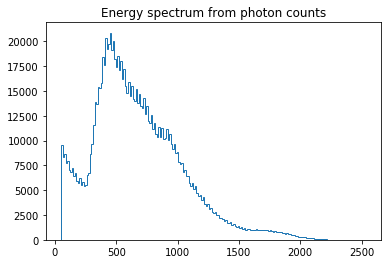

In [23]:
# check the energy spectrum in term of the tatal photon count from all events
fig, ax = plt.subplots()
#ax.set_xlim(min(E_photon), max(E_photon))
#plt.hist(E_photon, bins=200, range=(min(E_photon),max(E_photon)), histtype = 'step')
plt.hist(E_photon, bins=200, histtype = 'step')
ax.set_title("Energy spectrum from photon counts")
plt.savefig(".\\figs2\\Energy_spectrum_from_photon_counts.png", dpi=300)

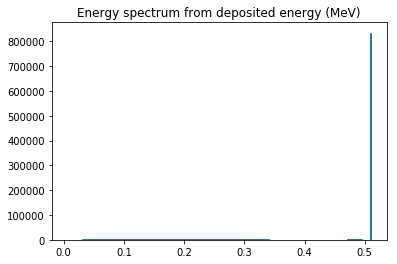

In [24]:
# check the energy spectrum in term of the tatal deposited energy (MeV)
fig, ax = plt.subplots()
# ax.set_xlim(min(E_photon), max(E_photon))
plt.hist(decoding[:,3], bins=200, histtype = 'step')
ax.set_title("Energy spectrum from deposited energy (MeV)")
plt.savefig(".\\figs2\\Energy_spectrum_from_deposited_energy.png", dpi=300)

###  
### 4. Conventional decoding methods and the associated 2D maps  
 \* For the details of the docoding algorithms please refer to the publication [A novel depth-of-interaction block detector for positron emission tomography using a dichotomous orthogonal sysmetry decoding concept](https://iopscience.iop.org/article/10.1088/0031-9155/61/4/1608).

***

#### 4.1 Anger-position decoding

In [25]:
E_top = X[:,0:18]
E_bottom = X[:,18:36]

E_x1 = E_top[:, 0:18:2]
E_x2 = E_top[:, 18:0:-2]

E_y1 = E_bottom[:, 0:18:2]
E_y2 = E_bottom[:, 18:0:-2]

In [26]:
E_left = np.sum(E_x1, axis = 1)
E_right = np.sum(E_x2, axis = 1)

E_front = np.sum(E_y1, axis = 1)
E_back = np.sum(E_y2, axis = 1)

In [27]:
E_h = E_left + E_right
E_h[E_h==0] = 1

E_v = E_front + E_back
E_v[E_v==0] = 1

In [28]:
x_t = np.array(E_left / E_h)
y_t = np.array(E_front / E_v)

#x_t[np.isnan(x_t)] = 0
#y_t[np.isnan(y_t)] = 0

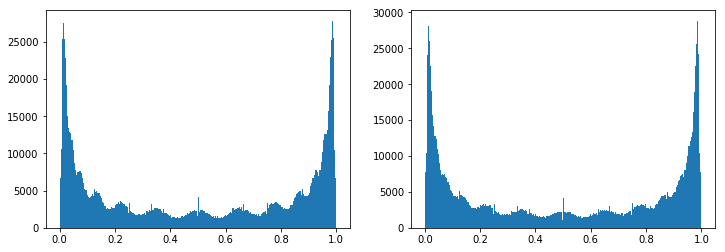

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

#ax.set_title('2d map from anger decoding')
ax[0].hist(x_t, bins=256)
ax[1].hist(y_t, bins=256)

plt.show()

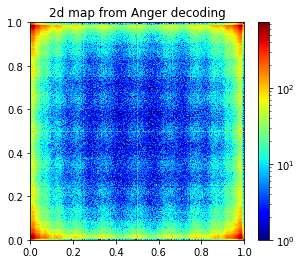

<Figure size 432x288 with 0 Axes>

In [30]:
fig, ax = plt.subplots(figsize=(4.8,4))

ax.set_title('2d map from Anger decoding')
#im = ax.hist2d(x_t, y_t, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=2000)
im = ax.hist2d(x_t, y_t, bins=256, norm = mpl.colors.LogNorm(), cmap=mpl.cm.jet)
fig.colorbar(im[3], ax=ax)
plt.show()
plt.savefig(".\\figs2\\2d_map_anger_decoding.png", dpi=300)

#### 4.2 Light-channel decoding

In [31]:
t0 = E_y1[:,0] + E_y2[:,0]

for j in range(1,9):
    t0 += (E_y1[:,j] + E_y2[:,j]) * (j+1)

x_b = np.array((t0 / (E_front+E_back) - 1) / 8)
x_b[np.isnan(x_b)] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [32]:
t0 = E_x1[:,0] + E_x2[:,0]

for j in range(1,9):
    t0 += (E_x1[:,j] + E_x2[:,j]) * (j+1)

y_b = np.array((t0 / (E_left+E_right) - 1) / 8)
y_b[np.isnan(y_b)] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


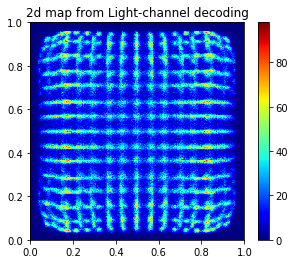

<Figure size 432x288 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(4.8,4))

ax.set_title('2d map from Light-channel decoding')

im = ax.hist2d(x_b, y_b, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=100)
fig.colorbar(im[3], ax=ax)

plt.show()
plt.savefig(".\\figs2\\2d_map_light_channel_decoding.png", dpi=300)

#### 4.3 Composite decoding

##### 4.3.1 arithmetic mean

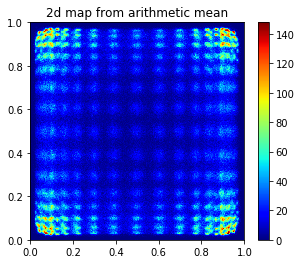

In [34]:
# x, y scale normalized to 1024
x_a =  (x_t + x_b) / 2 
y_a =  (y_t + y_b) / 2

fig, ax = plt.subplots(figsize=(4.8,4))
ax.set_title('2d map from arithmetic mean')
im = ax.hist2d(x_a, y_a, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=150)
fig.colorbar(im[3], ax=ax)
plt.savefig(".\\figs2\\2d_map_arithmetic_mean.png", dpi=300)
plt.show()


##### 4.3.2 geometric mean

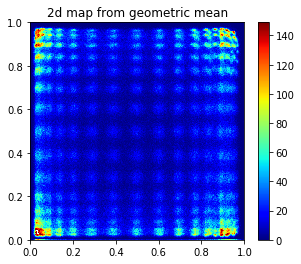

In [35]:
x_g = np.sqrt(x_t * x_b)
y_g = np.sqrt(y_t * y_b) 

fig, ax = plt.subplots(figsize=(4.8,4))
ax.set_title('2d map from geometric mean')
im = ax.hist2d(x_g, y_g, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=150)
fig.colorbar(im[3], ax=ax)
plt.savefig(".\\figs2\\2d_map_geometric_mean.png", dpi=300)
plt.show()


##### 4.3.3 Complex weight function

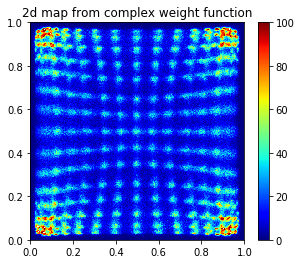

In [36]:
w = 1 - 0.7 * np.sqrt( (x_b-0.5)**2 + (y_b-0.5)**2 ) / 0.707
x_c = x_b * w + x_t * (1-w)
y_c = y_b * w + y_t * (1-w)

fig, ax = plt.subplots(figsize=(4.8,4))
ax.set_title('2d map from complex weight function')
im = ax.hist2d(x_c, y_c, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=100)
fig.colorbar(im[3], ax=ax)
plt.savefig(".\\figs2\\2d_map_comp_weight.png", dpi=300)
plt.show()


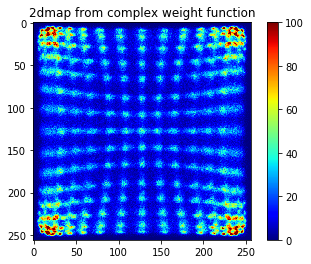

In [37]:
#histgram2d, xedges, yedges = np.histogram2d(x_c, y_c, bins=256, range=[[0,256],[0,256]])
histgram2d, xedges, yedges = np.histogram2d(y_c, x_c, bins=256, range=[[0,1],[0,1]])
im = plt.imshow(histgram2d, cmap='jet', vmax=100, vmin=0)
fig = plt.gcf()
ax = plt.gca()
fig.colorbar(im, ax=ax)
plt.title('2dmap from complex weight function')
plt.savefig(".//figs2//2d_map_comp_wight_1.png", dpi=300)

####  
#### 4.4  Scintillator/pixel discrimination using lookup table 


##### 4.4.1 Load the lookup table previously generated by conventional method based on the complex weight function

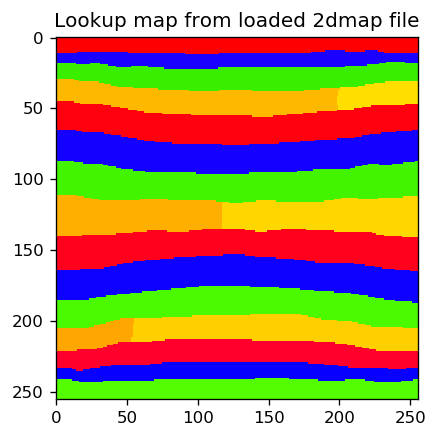

In [188]:
# read the 2D map
# twoD_map_datatype 
# big endian using '>'
twoD_map_datatype = np.dtype('>u4')

file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\new_concept_block4a_planar_source_comp1_bigendian_lut2.dat"
lut = np.fromfile(file, dtype=twoD_map_datatype).reshape((256,256))

fig1 = plt.imshow(lut, cmap='prism')
plt.title('Lookup map from loaded 2dmap file')
plt.savefig(".\\figs2\\lut_from_lut_file.png", dpi=300)


#####  
##### 4.4.2 Generate grid from the lookup table

In [39]:
# check the description in Part 1.

def generate_grid(lut):
    """
    generate the grid of the lookup table from the lookup table data
    
    input: lookup table, numpy array
    output: grid as numpy array, the same size as the input 
    """
    
    lut_grid = np.zeros(lut.shape)
    pix_x, pix_y = lut_grid.shape

    for i in range(pix_x-1):
        for j in range(pix_y-1):
            if lut[i,j] != lut[i+1,j]:
                lut_grid[i,j] = 1
                lut_grid[i+1,j] = 1
            if lut[i,j] != lut[i,j+1]:
                lut_grid[i,j] = 1
                lut_grid[i,j+1] = 1
    
    return lut_grid

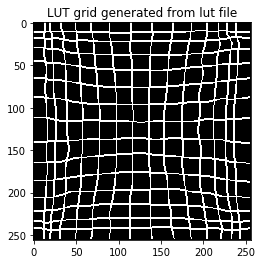

In [40]:
lut_grid = generate_grid(lut)

plt.imshow(lut_grid, cmap="gray")
plt.title("LUT grid generated from lut file")
plt.savefig(".\\figs2\\lut_grid_generated_from_lut_file.png", dpi=300)

#####  
##### 4.4.3 Overlap the lut grid with the 2dmap (histogram)

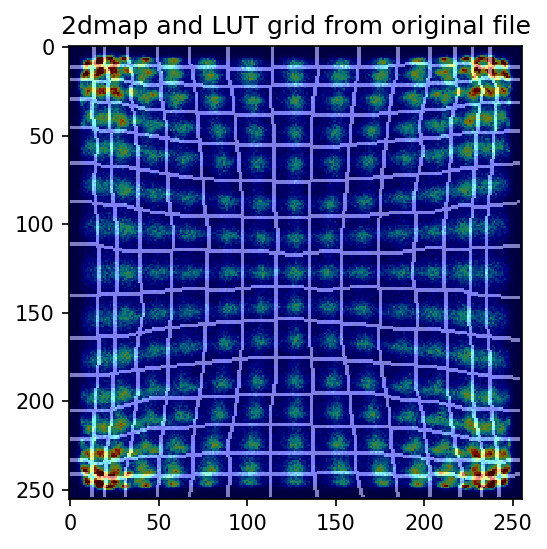

In [41]:
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
plt.rcParams['figure.dpi'] = 150

#plt.imshow(np.flip(histgram2d, axis=1), vmax = 100, cmap='jet')
plt.imshow(histgram2d, vmax = 100, cmap='jet')
plt.imshow(lut_grid, cmap="gray", alpha=0.5)
plt.title("2dmap and LUT grid from original file")
plt.savefig(".\\figs2\\2dmap_and_lut_grid_from_original_file.png", dpi=300)

plt.rcParams['figure.dpi'] = 120

####  
#### 4.4.4 Scintillator/pixel discrimination using lookup table


In [42]:
# deduce index_i and index_j from LUT

index_i=((lut/1000)-1).astype(int); # row index (Y)
index_j=lut%1000-1; # cloumn index (X)


* <b>define pixel_xy as the unique pixel/scintillator index in the 2d block as</b>
```
pixel_xy = index_y * 15 + index_x
```

<function matplotlib.pyplot.show(*args, **kw)>

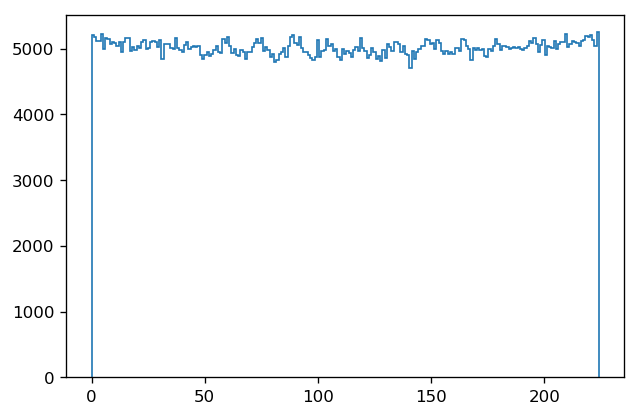

In [43]:
pixel_xy = np.array(df0['index_y'] * 15 + df0['index_x'])
plt.hist(pixel_xy, bins=225, histtype = 'step')
plt.show

In [44]:
def check_decoding (decoded_coor_x, decoded_coor_y, lut_index_i, lut_index_j, pixel_xy):
    '''
    check the decoding accuracy
    
    input decoded_coor_x, 
          decoded_coor_y: decoded x, y coordinates, range [0, 1], 1d float array, respectively
    input lut_index_i,
          lut_index_j: lookup table, 2D 256 x 256 array, resepectively,
                         decoded_index_x = lut_index_i[pixel_x *255, pixel_y*255]
                         decoded_index_y = lut_index_j[pixel_x *255, pixel_y*255]
    input pixel_xy : true index, pixel_xy = index_y * 15 + index_x
    
    decoded_xy = decoded_index_y * 15 + decoded_index_x

    output accuracy: sum(decoded_xy == pixel_xy) / pixel_xy.size
    '''
   
    decoded_index_y = lut_index_i[(decoded_coor_y * 255).astype(int), (decoded_coor_x * 255).astype(int)]
    decoded_index_x = lut_index_j[(decoded_coor_y * 255).astype(int), (decoded_coor_x * 255).astype(int)]

    decoded_xy =  np.array(decoded_index_y * 15 + decoded_index_x)
        
    #print (sum(decoded_xy == pixel_xy), pixel_xy.size)
    accuracy = sum(decoded_xy == pixel_xy) / pixel_xy.size

    return accuracy, decoded_xy
    
    

In [45]:
#m=1000000
m=pixel_xy.size
accu, decoded_xy = check_decoding(x_c[:m], y_c[:m], index_i, index_j, pixel_xy[:m])

In [46]:
accu

0.5217637443686959

* <b>Therefore, the decoding accuracy with the lookup table is 0.522.</b>
***

###  
### 5. Scintillator/Pixel discrimination using ML algorithms - Part I, regression algorithms
***

####  
#### 5.1 pixel index vs. individual SiPM counts

<function matplotlib.pyplot.show(*args, **kw)>

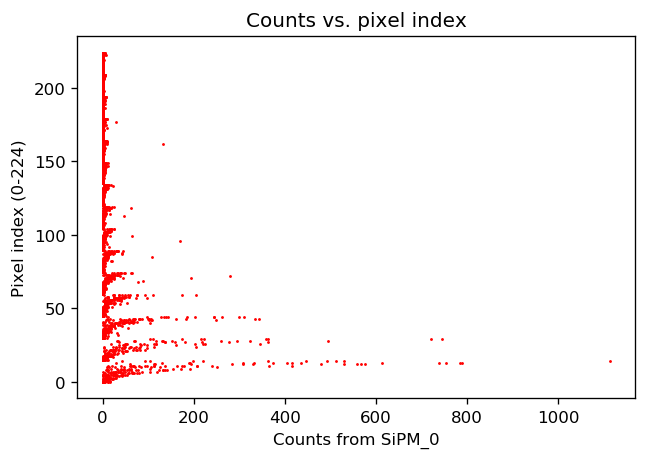

In [47]:
N=3000
plt.scatter(X[:N,0], pixel_xy[0:N], color = 'red', s=0.5)
plt.title('Counts vs. pixel index')
plt.xlabel('Counts from SiPM_0')
plt.ylabel('Pixel index (0-224)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

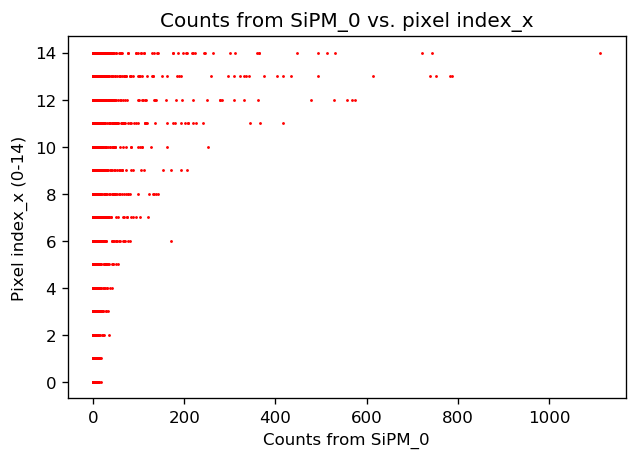

In [48]:
N=3000
plt.scatter(X[:N,0], df0['index_x'][0:N], color = 'red', s=0.5)
plt.title('Counts from SiPM_0 vs. pixel index_x')
plt.xlabel('Counts from SiPM_0')
plt.ylabel('Pixel index_x (0-14)')
plt.show

* <b>Pixel index does not have simple relationship to individual SiPM counts!</b>

####  
#### 5.2 pixel index vs. combined SiPM counts

[Text(0, 0.5, 'index_x (red) and index_y (blue)'), Text(0.5, 0, 'x_b, y_b')]

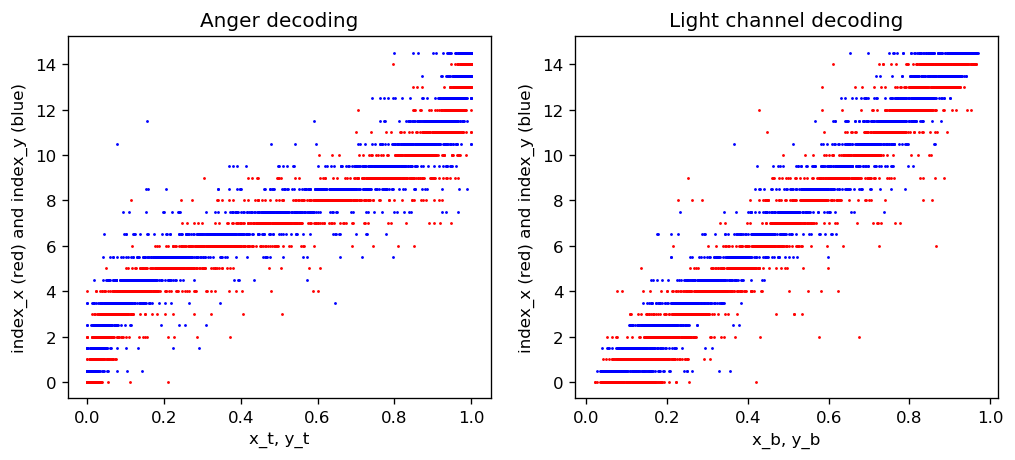

In [49]:
# E_left, E_right, E_front， E_back

# Anger decoding
# x_t, y_t

# light channel docoding
# x_b, y_b
N=3000

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].title.set_text('Anger decoding')
ax[0].scatter(x_t[:N], df0['index_x'][0:N], color = 'red', s=0.5)
ax[0].scatter(y_t[:N], df0['index_y'][0:N]+0.5, color = 'blue', s=0.5)
ax[0].set(xlabel='x_t, y_t', ylabel='index_x (red) and index_y (blue)')

ax[1].title.set_text('Light channel decoding')
ax[1].scatter(x_b[:N], df0['index_x'][0:N], color = 'red', s=0.5)
ax[1].scatter(y_b[:N], df0['index_y'][0:N]+0.5, color = 'blue', s=0.5)
ax[1].set(xlabel='x_b, y_b', ylabel='index_x (red) and index_y (blue)')


* <b>Pixel index have a monotonic relationship to the combined SiPM counts, therefore, regression or classification algorithms might work!</b>

####  
#### 5.3 pixel discrimination using regression algorithms - using pixel index as the only one output

In [50]:
#==============================================================================
# split the dataset into training and test set use 80/20 approach
#==============================================================================

from sklearn.model_selection import train_test_split

index = np.arange(X[:,0].size)
X_train, X_test, pixel_xy_train, pixel_xy_test, index_train, index_test = \
        train_test_split (X, pixel_xy, index, test_size = 0.2, random_state = 0)


In [51]:
accu, decoded_xy = check_decoding(x_c[index_test], y_c[index_test], index_i, index_j, pixel_xy[index_test])
print ('accuracy for the testing data is %f.'%accu)

accuracy for the testing data is 0.521898.


In [52]:
accu, decoded_xy = check_decoding(x_c[index_train], y_c[index_train], index_i, index_j, pixel_xy[index_train])
print ('accuracy for the trainning data is %f.'%accu)

accuracy for the trainning data is 0.521730.


#####  
##### 5.3.1 linear regression


In [53]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, pixel_xy_train)
lin_reg.intercept_, lin_reg.coef_

(112.10517366517637,
 array([-0.06849888,  0.06806856, -0.06789525,  0.06890463, -0.0524121 ,
         0.05115546, -0.02265603,  0.02334874,  0.00681716, -0.00731927,
         0.03822236, -0.03849436,  0.06498417, -0.06435202,  0.07922839,
        -0.08078829,  0.0750127 , -0.07471007,  0.06775116, -0.06825595,
         0.10364466, -0.10571765,  0.12718253, -0.12789485,  0.13836742,
        -0.14103274,  0.13603968, -0.13577657,  0.14183952, -0.14499515,
         0.1385801 , -0.13581617,  0.11918745, -0.1198089 ,  0.08437269,
        -0.08250363]))

In [54]:
y_pred = lin_reg.predict(X_test)

In [55]:
y_pred.astype(int)

array([167,  72,  86, ..., 158, 106,  68])

In [56]:
(y_pred+0.5).astype(int)

array([168,  73,  87, ..., 159, 106,  68])

In [57]:
pixel_xy_test

array([187,  10,  77, ..., 217,  49,  71], dtype=int64)

In [58]:
accu_lin_reg = sum(pixel_xy_test==y_pred.astype(int))/pixel_xy_test.size
print('accuracy from linear regression: %f'%accu_lin_reg)

accuracy from linear regression: 0.029325


In [59]:
accu_lin_reg = sum(pixel_xy_test==(y_pred+0.5).astype(int))/pixel_xy_test.size
print('accuracy from linear regression: %f'%accu_lin_reg)

accuracy from linear regression: 0.029267


* <b>The accuracy from linear regression is unacceptable!</b>

#####  
##### 5.3.2 polynomial regression using original SiPM counts

In [60]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
N=10000
X_train_poly = poly_features.fit_transform(X_train[:N])

In [61]:
X_test_poly = poly_features.transform(X_test)

In [62]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train_poly, pixel_xy_train[:N])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [63]:
pixel_xy_poly_pred = lin_reg2.predict(X_test_poly)

In [64]:
accu_poly_reg = sum(pixel_xy_test==pixel_xy_poly_pred.astype(int))/pixel_xy_test.size
print('accuracy from polynomial regression: %f'%accu_poly_reg)

accuracy from polynomial regression: 0.005550


In [65]:
accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly_pred+0.5).astype(int))/pixel_xy_test.size
print('accuracy from polynomial regression: %f'%accu_poly_reg)

accuracy from polynomial regression: 0.005395


* <b>Polynomial(degree=2), accuracy = 0.064714</b>
* <b>Polynomial(degree=3), the polynmial fit_transform function will run out of memory with the whole training data set with 16GB memory under Windows 10, therefore, we limited the training data set size to 10000, and the accuracy = 0.005550, basically unacceptable.</b>

#####  
#####  5.3.3 polynomial regression using Anger decoding (x_t, y_t) or Light Channel decoding signal (x_b, y_b)

In [66]:
# Ander decoding using x_t, y_t

poly_features2 = PolynomialFeatures(degree=9, include_bias=False)
X_t = np.hstack((x_t.reshape(-1,1), y_t.reshape(-1,1)))
X_train2 = X_t[index_train]
X_test2 = X_t[index_test] 
X_train2_poly = poly_features2.fit_transform(X_train2)
X_test2_poly = poly_features2.transform(X_test2)

In [67]:
lin_reg_t = LinearRegression()
lin_reg_t.fit(X_train2_poly, pixel_xy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [68]:
pixel_xy_poly2_pred = lin_reg_t.predict(X_test2_poly)

accu_poly_reg = sum(pixel_xy_test==pixel_xy_poly2_pred.astype(int))/pixel_xy_test.size
print('accuracy from polynomial regression: %f'%accu_poly_reg)

accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly2_pred+0.5).astype(int))/pixel_xy_test.size
print('accuracy from polynomial regression: %f'%accu_poly_reg)


accuracy from polynomial regression: 0.053161
accuracy from polynomial regression: 0.053777


* <b>Polynomial(degree=3), accuracy = 0.045803</b>
* <b>Polynomial(degree=4), accuracy = 0.045715</b>
* <b>Polynomial(degree=5), accuracy = 0.051886</b>
* <b>Polynomial(degree=9), accuracy = 0.053161</b>

In [69]:

# light decoding using x_b, y_b

poly_features2 = PolynomialFeatures(degree=21, include_bias=False)
X_b = np.hstack((x_b.reshape(-1,1), y_b.reshape(-1,1)))
X_train2 = X_b[index_train]
X_test2 = X_b[index_test] 
X_train2_poly = poly_features2.fit_transform(X_train2)
X_test2_poly = poly_features2.transform(X_test2)

lin_reg_b = LinearRegression()
lin_reg_b.fit(X_train2_poly, pixel_xy_train)


pixel_xy_poly2_pred = lin_reg_b.predict(X_test2_poly)

accu_poly_reg = sum(pixel_xy_test==pixel_xy_poly2_pred.astype(int))/pixel_xy_test.size
print('accuracy from polynomial regression: %f'%accu_poly_reg)

accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly2_pred+0.5).astype(int))/pixel_xy_test.size
print('accuracy from polynomial regression: %f'%accu_poly_reg)

accuracy from polynomial regression: 0.083877
accuracy from polynomial regression: 0.088125


* <b>Polynomial(degree=3), accuracy = 0.067173</b>
* <b>Polynomial(degree=5), accuracy = 0.072440</b>
* <b>Polynomial(degree=7), accuracy = 0.074278</b>
* <b>Polynomial(degree=9), accuracy = 0.075022</b>
* <b>Polynomial(degree=15), accuracy = 0.081547</b>


In [70]:

# composite decoding x_a, y_a

X_a = np.hstack((x_a.reshape(-1,1), y_a.reshape(-1,1)))
X_train2 = X_a[index_train]
X_test2 = X_a[index_test] 

for i in (2,3,5,7,9,15,21):
    poly_features2 = PolynomialFeatures(degree=i, include_bias=False)

    X_train2_poly = poly_features2.fit_transform(X_train2)
    X_test2_poly = poly_features2.transform(X_test2)

    lin_reg_a = LinearRegression()
    lin_reg_a.fit(X_train2_poly, pixel_xy_train)


    pixel_xy_poly2_pred = lin_reg_a.predict(X_test2_poly)

    accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly2_pred+.5).astype(int))/pixel_xy_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))

#    accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly2_pred+0.5).astype(int))/pixel_xy_test.size
#    print('accuracy from polynomial regression: %f'%accu_poly_reg)

accuracy from polynomial regression (degree=2): 0.023938
accuracy from polynomial regression (degree=3): 0.071700
accuracy from polynomial regression (degree=5): 0.072338
accuracy from polynomial regression (degree=7): 0.074654
accuracy from polynomial regression (degree=9): 0.075536
accuracy from polynomial regression (degree=15): 0.078902
accuracy from polynomial regression (degree=21): 0.080019


In [71]:

# composite decoding x_g, y_g
X_g = np.hstack((x_g.reshape(-1,1), y_g.reshape(-1,1)))
X_train2 = X_g[index_train]
X_test2 = X_g[index_test] 

for i in (2,3,5,7,9,15):
    poly_features2 = PolynomialFeatures(degree=i, include_bias=False)

    X_train2_poly = poly_features2.fit_transform(X_train2)
    X_test2_poly = poly_features2.transform(X_test2)

    lin_reg_g = LinearRegression()
    lin_reg_g.fit(X_train2_poly, pixel_xy_train)


    pixel_xy_poly2_pred = lin_reg_g.predict(X_test2_poly)

    accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly2_pred+0.5).astype(int))/pixel_xy_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))



accuracy from polynomial regression (degree=2): 0.024519
accuracy from polynomial regression (degree=3): 0.066738
accuracy from polynomial regression (degree=5): 0.069241
accuracy from polynomial regression (degree=7): 0.068674
accuracy from polynomial regression (degree=9): 0.068555
accuracy from polynomial regression (degree=15): 0.078477


In [72]:

# complex weight function decoding x_c, y_c

X_c = np.hstack((x_c.reshape(-1,1), y_c.reshape(-1,1)))
X_train2 = X_c[index_train]
X_test2 = X_c[index_test] 

for i in (2,3,5,7,9,15):
    poly_features2 = PolynomialFeatures(degree=i, include_bias=False)

    X_train2_poly = poly_features2.fit_transform(X_train2)
    X_test2_poly = poly_features2.transform(X_test2)

    lin_reg_c = LinearRegression()
    lin_reg_c.fit(X_train2_poly, pixel_xy_train)


    pixel_xy_poly2_pred = lin_reg_c.predict(X_test2_poly)

    accu_poly_reg = sum(pixel_xy_test==(pixel_xy_poly2_pred+0.5).astype(int))/pixel_xy_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))


accuracy from polynomial regression (degree=2): 0.046951
accuracy from polynomial regression (degree=3): 0.071026
accuracy from polynomial regression (degree=5): 0.077281
accuracy from polynomial regression (degree=7): 0.078003
accuracy from polynomial regression (degree=9): 0.078801
accuracy from polynomial regression (degree=15): 0.082610


####  
#### 5.4 pixel discrimination using regression algorithms - using seperated x and y indices as the output

#####  
##### 5.4.0 plot prediction result

In [135]:
from sklearn.utils import check_random_state

def random_cmap(ncolors=256, random_state=None):
    """
    Generate a matplotlib colormap consisting of random (muted) colors.

    A random colormap is very useful for plotting segmentation images.

    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.

    random_state : int or `~numpy.random.RandomState`, optional
        The pseudo-random number generator state used for random
        sampling.  Separate function calls with the same
        ``random_state`` will generate the same colormap.

    Returns
    -------
    cmap : `matplotlib.colors.Colormap`
        The matplotlib colormap with random colors.
    """

    from matplotlib import colors

    prng = check_random_state(random_state)
    h = prng.uniform(low=0.0, high=1.0, size=ncolors)
    s = prng.uniform(low=0.4, high=0.9, size=ncolors)
    v = prng.uniform(low=0.7, high=1.0, size=ncolors)
    hsv = np.dstack((h, s, v))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(rgb)

In [204]:
def plot_prediction_boundary(reg_func1, reg_func2, prep_func, cmap='hsv', axes=[0, 1.0, 0, 1.0], legend=False):
    fig, ax = plt.subplots(figsize=(4,4))
    
    x1s = np.linspace(axes[0], axes[1], 256)
    x2s = np.linspace(axes[2], axes[3], 256)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y1_pred = (reg_func1.predict(prep_func.transform(X_new))+0.5).astype(int).reshape(x1.shape)
    y2_pred = (reg_func2.predict(prep_func.transform(X_new))+0.5).astype(int).reshape(x1.shape)

    lut_pred = y1_pred+y2_pred*15
    plt.imshow(lut_pred, alpha=0.5, cmap=cmap)
    
    return lut_pred
    

#####  
##### 5.4.1 polynomial regression

In [74]:
# pixel_xy = np.array(df0['index_y'] * 15 + df0['index_x'])
pixel_x = np.array(df0['index_x'])
pixel_y = np.array(df0['index_y'])

pixel_x_train = pixel_x[index_train]
pixel_y_train = pixel_y[index_train]

pixel_x_test = pixel_x[index_test]
pixel_y_test = pixel_y[index_test]


In [215]:

# Anger decoding x_t, y_t

X_t = np.hstack((x_t.reshape(-1,1), y_t.reshape(-1,1)))
X_train = X_t[index_train]
X_test = X_t[index_test] 

#for i in (1,2,3,4,5,6,7,9,11,15):
for i in (1,3,5,7):

    poly_features = PolynomialFeatures(degree=i, include_bias=False)

    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    lin_reg_a_x = LinearRegression()
    lin_reg_a_y = LinearRegression()
    lin_reg_a_x.fit(X_train_poly, pixel_x_train)
    lin_reg_a_y.fit(X_train_poly, pixel_y_train)


    pixel_x_pred = lin_reg_a_x.predict(X_test_poly)
    pixel_y_pred = lin_reg_a_y.predict(X_test_poly)

    accu_poly_reg = sum(np.logical_and(pixel_x_test==(pixel_x_pred+.5).astype(int), pixel_y_test==(pixel_y_pred+.5).astype(int))) / pixel_x_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))
    

accuracy from polynomial regression (degree=1): 0.071726
accuracy from polynomial regression (degree=3): 0.319765
accuracy from polynomial regression (degree=5): 0.452626
accuracy from polynomial regression (degree=7): 0.475891


<b>
accuracy from polynomial regression (degree=1): 0.071726  
 
accuracy from polynomial regression (degree=2): 0.071775  
accuracy from polynomial regression (degree=3): 0.319765  
accuracy from polynomial regression (degree=4): 0.319774  
accuracy from polynomial regression (degree=5): 0.452626  
accuracy from polynomial regression (degree=6): 0.452604  
accuracy from polynomial regression (degree=7): 0.475891  
accuracy from polynomial regression (degree=9): 0.474314  
accuracy from polynomial regression (degree=11): 0.471275  
accuracy from polynomial regression (degree=15): 0.487989  
</b>

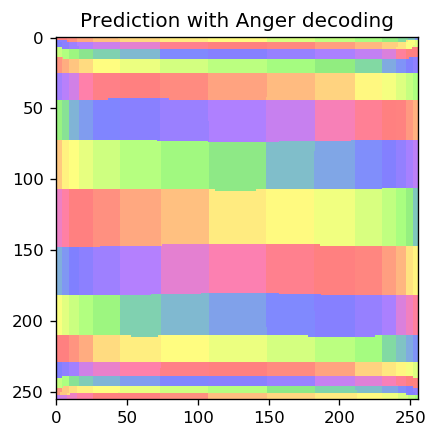

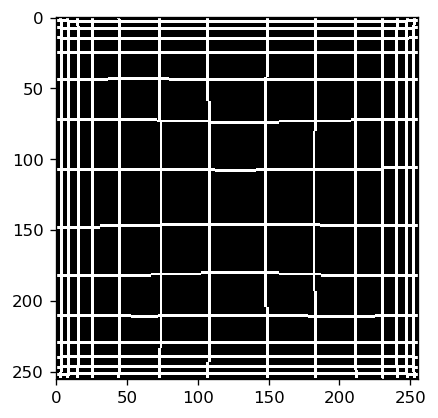

In [217]:
lut_pred = plot_prediction_boundary(lin_reg_a_x, lin_reg_a_y, poly_features, cmap='prism', axes=[0, 1.0, 0, 1.0], legend=False)
plt.gcf()
plt.title("Prediction with Anger decoding")
plt.savefig(".\\figs2\\Prediction_with_Anger_decoding.png", dpi=300)

plt.figure()
plt.imshow(generate_grid(lut_pred), cmap='gray')
plt.savefig(".\\figs2\\Prediction_with_Anger_decoding_grid.png", dpi=300)


In [224]:

# light channel decoding x_b, y_b

X_b = np.hstack((x_b.reshape(-1,1), y_b.reshape(-1,1)))
X_train = X_b[index_train]
X_test = X_b[index_test] 

#for i in (1,2,3,4,5,6,7,8):
for i in (3,4,5,6,7):
    poly_features = PolynomialFeatures(degree=i, include_bias=False)

    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    lin_reg_a_x = LinearRegression()
    lin_reg_a_y = LinearRegression()
    lin_reg_a_x.fit(X_train_poly, pixel_x_train)
    lin_reg_a_y.fit(X_train_poly, pixel_y_train)


    pixel_x_pred = lin_reg_a_x.predict(X_test_poly)
    pixel_y_pred = lin_reg_a_y.predict(X_test_poly)

    accu_poly_reg = sum(np.logical_and(pixel_x_test==(pixel_x_pred+.5).astype(int), pixel_y_test==(pixel_y_pred+.5).astype(int))) / pixel_x_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))

accuracy from polynomial regression (degree=3): 0.502089
accuracy from polynomial regression (degree=4): 0.502111
accuracy from polynomial regression (degree=5): 0.497805
accuracy from polynomial regression (degree=6): 0.497805
accuracy from polynomial regression (degree=7): 0.499112


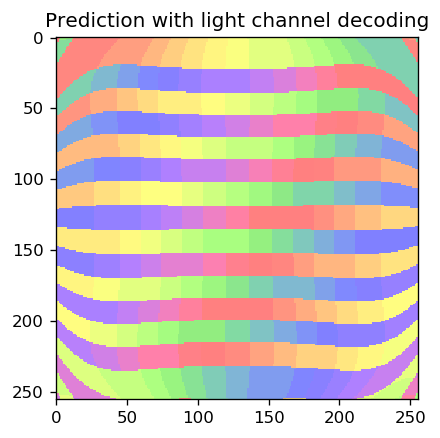

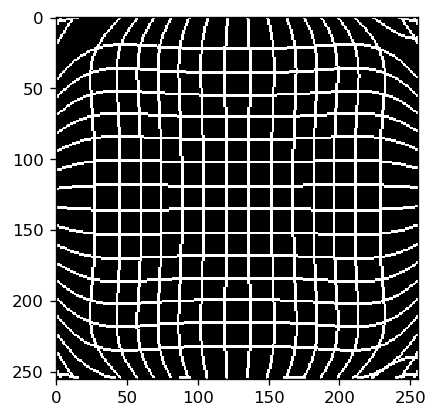

In [225]:
lut_pred = plot_prediction_boundary(lin_reg_a_x, lin_reg_a_y, poly_features, cmap='prism', axes=[0, 1.0, 0, 1.0], legend=False)
plt.gcf()
plt.title("Prediction with light channel decoding")
plt.savefig(".\\figs2\\Prediction_with_light_channel_decoding.png", dpi=300)

plt.figure()
plt.imshow(generate_grid(lut_pred), cmap='gray')
plt.savefig(".\\figs2\\Prediction_with_light_channel_decoding_grid.png", dpi=300)


In [230]:

# composite decoding x_a, y_a

X_a = np.hstack((x_a.reshape(-1,1), y_a.reshape(-1,1)))
X_train = X_a[index_train]
X_test = X_a[index_test] 

for i in (1,2,3,4,5):
    poly_features = PolynomialFeatures(degree=i, include_bias=False)

    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    lin_reg_a_x = LinearRegression()
    lin_reg_a_y = LinearRegression()
    lin_reg_a_x.fit(X_train_poly, pixel_x_train)
    lin_reg_a_y.fit(X_train_poly, pixel_y_train)


    pixel_x_pred = lin_reg_a_x.predict(X_test_poly)
    pixel_y_pred = lin_reg_a_y.predict(X_test_poly)

    accu_poly_reg = sum(np.logical_and(pixel_x_test==(pixel_x_pred+.5).astype(int), pixel_y_test==(pixel_y_pred+.5).astype(int))) / pixel_x_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))


accuracy from polynomial regression (degree=1): 0.204393
accuracy from polynomial regression (degree=2): 0.204291
accuracy from polynomial regression (degree=3): 0.553141
accuracy from polynomial regression (degree=4): 0.553186
accuracy from polynomial regression (degree=5): 0.556211


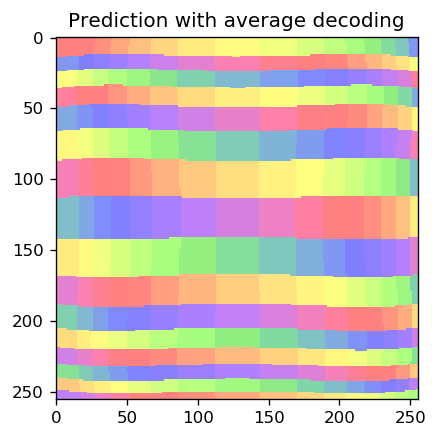

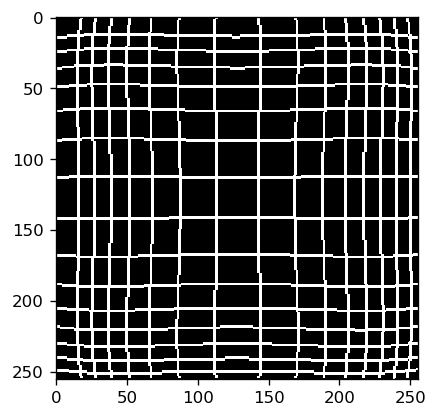

In [231]:
lut_pred = plot_prediction_boundary(lin_reg_a_x, lin_reg_a_y, poly_features, cmap='prism', axes=[0, 1.0, 0, 1.0], legend=False)
plt.gcf()
plt.title("Prediction with average decoding")
plt.savefig(".\\figs2\\Prediction_with_average_decoding.png", dpi=300)

plt.figure()
plt.imshow(generate_grid(lut_pred), cmap='gray')
plt.savefig(".\\figs2\\Prediction_with_average_decoding_grid.png", dpi=300)


* <b>With degree = 3, the prediction reaches the plateau with the accuracy of 0.553, which exceeds the lookup table result of 0.522!</b>


In [232]:

# composite decoding x_g, y_g

X_g = np.hstack((x_g.reshape(-1,1), y_g.reshape(-1,1)))
X_train = X_g[index_train]
X_test = X_g[index_test] 

for i in (1,2,3,4,5):
    poly_features = PolynomialFeatures(degree=i, include_bias=False)

    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    lin_reg_a_x = LinearRegression()
    lin_reg_a_y = LinearRegression()
    lin_reg_a_x.fit(X_train_poly, pixel_x_train)
    lin_reg_a_y.fit(X_train_poly, pixel_y_train)


    pixel_x_pred = lin_reg_a_x.predict(X_test_poly)
    pixel_y_pred = lin_reg_a_y.predict(X_test_poly)

    accu_poly_reg = sum(np.logical_and(pixel_x_test==(pixel_x_pred+.5).astype(int), pixel_y_test==(pixel_y_pred+.5).astype(int))) / pixel_x_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))

accuracy from polynomial regression (degree=1): 0.212158
accuracy from polynomial regression (degree=2): 0.211591
accuracy from polynomial regression (degree=3): 0.540844
accuracy from polynomial regression (degree=4): 0.551790
accuracy from polynomial regression (degree=5): 0.555795


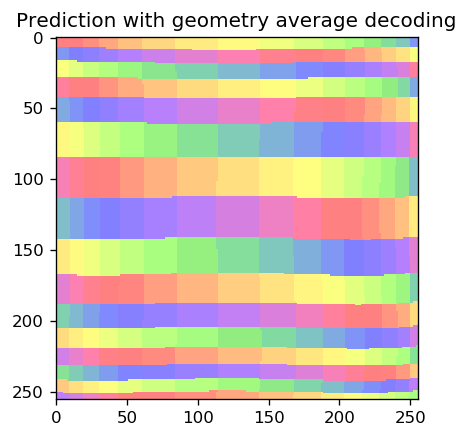

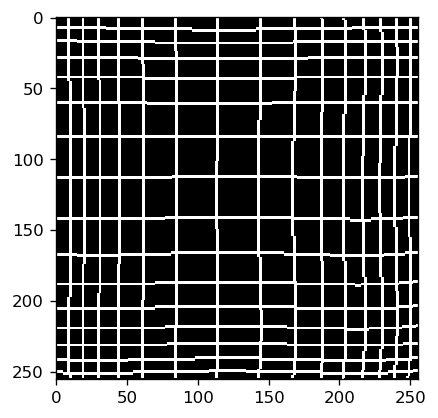

In [233]:
lut_pred = plot_prediction_boundary(lin_reg_a_x, lin_reg_a_y, poly_features, cmap='prism', axes=[0, 1.0, 0, 1.0], legend=False)
plt.gcf()
plt.title("Prediction with geometry average decoding")
plt.savefig(".\\figs2\\Prediction_with_geometry_decoding.png", dpi=300)

plt.figure()
plt.imshow(generate_grid(lut_pred), cmap='gray')
plt.savefig(".\\figs2\\Prediction_with_geometry_decoding_grid.png", dpi=300)


In [235]:

# complex weight function decoding x_c, y_c

X_c = np.hstack((x_c.reshape(-1,1), y_c.reshape(-1,1)))
X_train = X_c[index_train]
X_test = X_c[index_test] 

#for i in (1,2,3,4,5,6,7,8,9,11):
for i in (1,2,3,5,7,9,11):
    poly_features = PolynomialFeatures(degree=i, include_bias=False)

    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    lin_reg_a_x = LinearRegression()
    lin_reg_a_y = LinearRegression()
    lin_reg_a_x.fit(X_train_poly, pixel_x_train)
    lin_reg_a_y.fit(X_train_poly, pixel_y_train)


    pixel_x_pred = lin_reg_a_x.predict(X_test_poly)
    pixel_y_pred = lin_reg_a_y.predict(X_test_poly)

    accu_poly_reg = sum(np.logical_and(pixel_x_test==(pixel_x_pred+.5).astype(int), pixel_y_test==(pixel_y_pred+.5).astype(int))) / pixel_x_test.size
    print('accuracy from polynomial regression (degree=%d): %f' % (i,accu_poly_reg))

accuracy from polynomial regression (degree=1): 0.353808
accuracy from polynomial regression (degree=2): 0.353803
accuracy from polynomial regression (degree=3): 0.527081
accuracy from polynomial regression (degree=5): 0.546045
accuracy from polynomial regression (degree=7): 0.545469
accuracy from polynomial regression (degree=9): 0.546178
accuracy from polynomial regression (degree=11): 0.546435


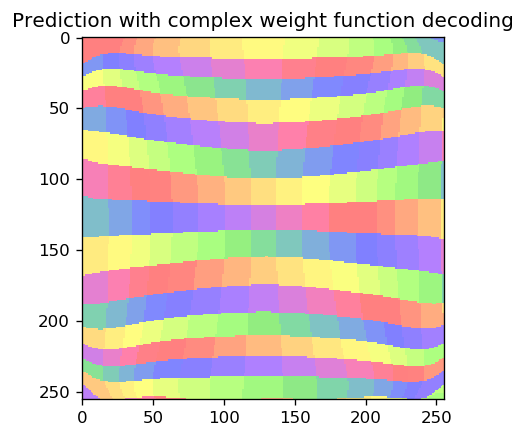

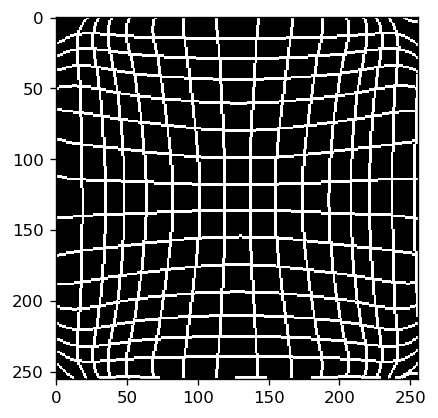

In [236]:
lut_pred = plot_prediction_boundary(lin_reg_a_x, lin_reg_a_y, poly_features, cmap='prism', axes=[0, 1.0, 0, 1.0], legend=False)
plt.gcf()
plt.title("Prediction with complex weight function decoding")
plt.savefig(".\\figs2\\Prediction_with_complex_weight_function_decoding.png", dpi=300)

plt.figure()
plt.imshow(generate_grid(lut_pred), cmap='gray')
plt.savefig(".\\figs2\\Prediction_with_complex_weight_function_decoding_grid.png", dpi=300)

####  
#### 5.5 Using logistic regression
***

In [292]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [290]:
def plot_prediction_boundary3(reg_func, cmap='hsv', alpha=1, axes=[0, 1.0, 0, 1.0], title='', ax=None):
    '''
    fitting the data with one function, the prediction is the unique pixel index
    '''
    if ax == None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    x1s = np.linspace(axes[0], axes[1], 256)
    x2s = np.linspace(axes[2], axes[3], 256)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    pixel_xy_pred = reg_func.predict(X_new).reshape(x1.shape)

    lut_pred = pixel_xy_pred
    ax.imshow(lut_pred, alpha=alpha, cmap=cmap)
    ax.set_title(title)

    return lut_pred


In [289]:
def test_logisticRegression(X, y, index_train, index_test):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]

    lr = LogisticRegression(C=1, random_state=1, solver ='newton-cg', tol=.001, n_jobs=8)
    lr.fit(X_train, y[index_train])
    pixel_xy_pred = lr.predict(X_test)

    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
    
    print('accuracy score: %f' % (metrics.accuracy_score(y[index_test], pixel_xy_pred)))
        
    return lr


=== Anger docoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.201120
=== Light Channel decoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.209121
=== Arithmatic mean ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.240024
=== Geometric mean ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.246125
=== Complex weight function ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.234123


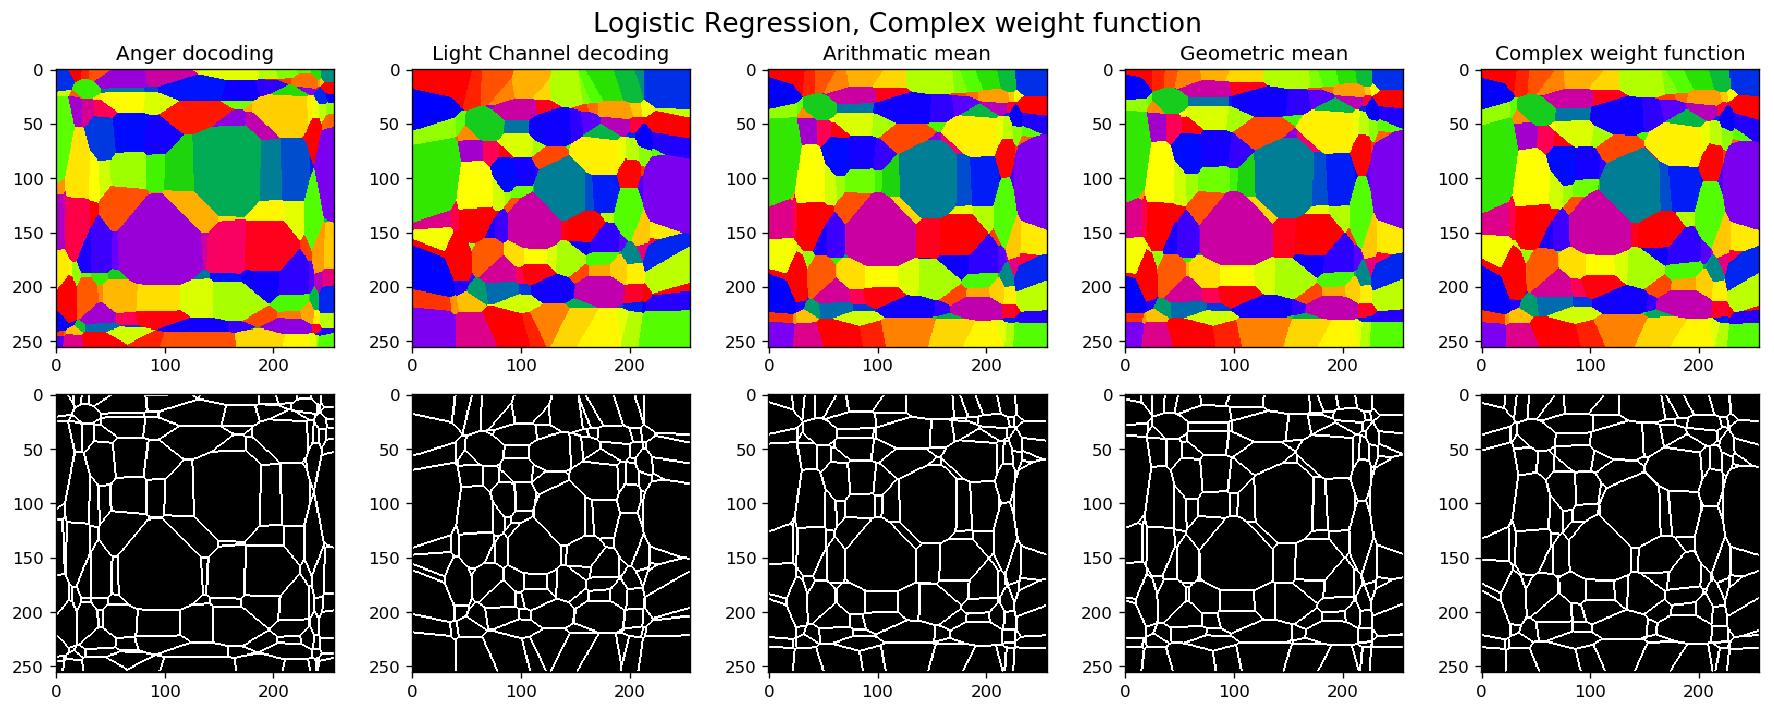

In [301]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
fig.suptitle("Logistic Regression, " + notes, fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')) ):
    print ('=== %s ==='%notes)
    
    clf = test_logisticRegression(X, pixel_xy, index_train[1:10000], index_test[1:10000])
    lut_pred = plot_prediction_boundary3(clf, cmap='prism', title=notes,  ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')


=== Anger docoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.386508
=== Light Channel decoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.375265
=== Arithmatic mean ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.446314
=== Geometric mean ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.469982
=== Complex weight function ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 0.407864


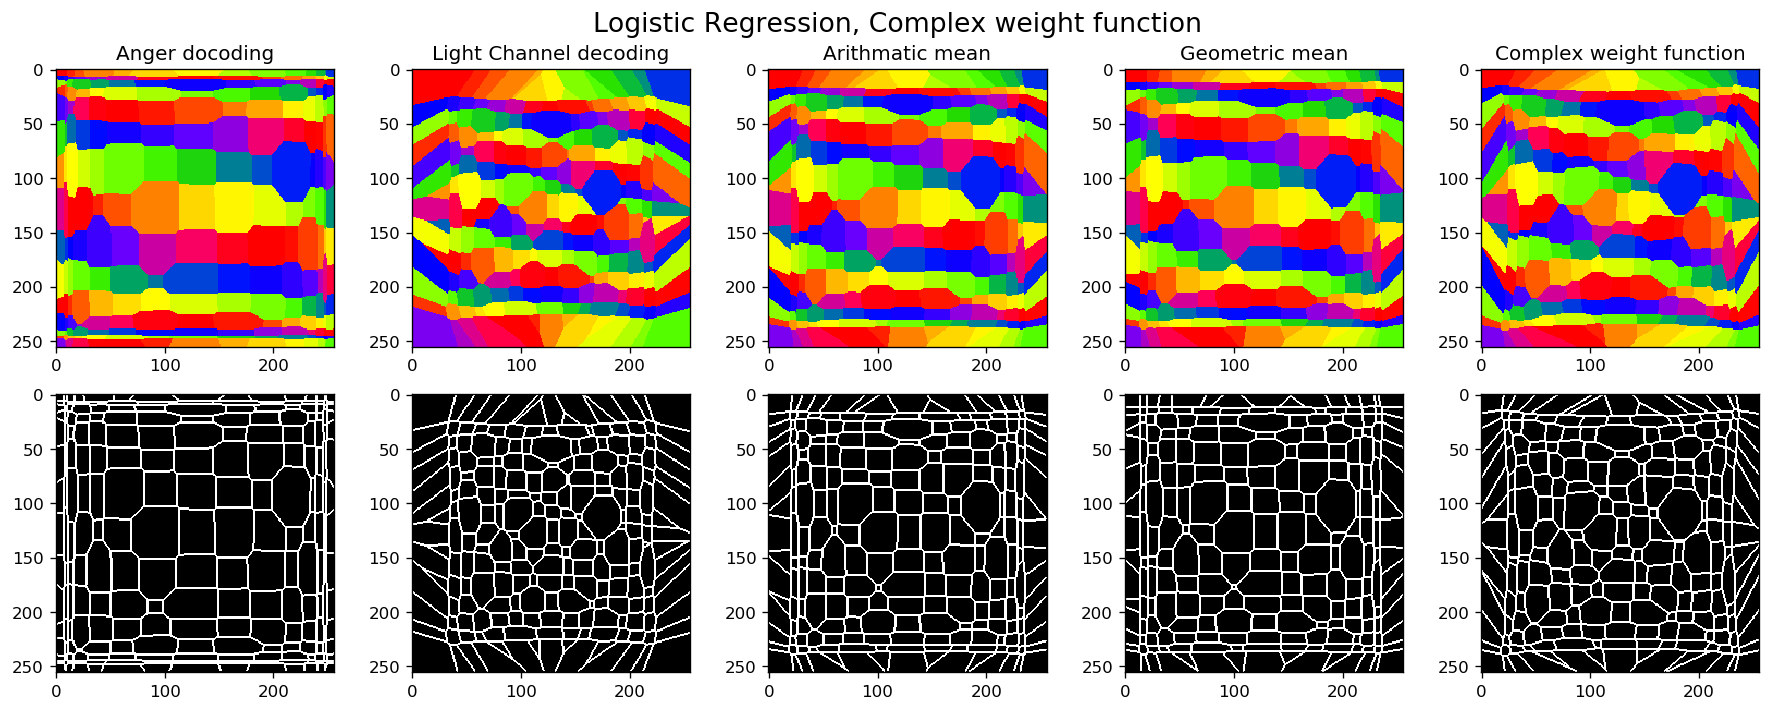

In [302]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
fig.suptitle("Logistic Regression, " + notes, fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')) ):
    print ('=== %s ==='%notes)
    
    clf = test_logisticRegression(X, pixel_xy, index_train, index_test)
    lut_pred = plot_prediction_boundary3(clf, cmap='prism', title=notes,  ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')


####  
#### 5.6 Conclusion for regression algorithms
***
* The regression algorithms using one output variable for the pixel index won't work.
* Two output variables along X and Y axis are needed.
* Polynomial Regreesion using all independed photo sensors as the input variables requires large amount of memory and may not yiedl good results.
* Using processed energy distributions (summed photons in each side) as the input variables could provide good results.
* Light channel decoding with polynomial regression could achieve 0.55 accuracy, compare to 0.52 accuracy using conventional method using lookup table.
* Arithmatic average, Geometric average and complex weight average all provide similar accuracy from 0.54 to 0.55.
* Logistic regression runs much slow than other methods, and its performance is poor. Best accuracy with geometric mean is 0.47.

##  
## Continued in [Part 2-2](https://)

In [266]:
import pickle

datafile = open('./pickle/temp_data1','wb')

temp_data = [X_t, X_b, X_a, X_g, X_c, index_train, index_test]
pickle.dump(temp_data, datafile)

datafile.close()

## To be continued...